<div>
<img src="img/banner.png" width="2500"/>
</div>

In [2]:
import numpy as np
import pandas as pd
import panel as pn
pn.extension('tabulator')
import hvplot
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import time
import os
from sklearn import metrics
from scipy.stats import zscore

<br><br><br>

<div>
<img src="img/I-1.png" width="2500"/>
</div>


**L'ensemble de données KDD99** est un ensemble de données volumineux et complexe avec de nombreuses fonctionnalités et types d'attaques. Pour le rendre plus accessible, une version prétraitée appelée **kddcup.data_10_percent** a été créée. Cette version contient un échantillon aléatoire de **10 %** de l'ensemble de données d'origine, ce qui réduit le coût et le temps de calcul nécessaires pour créer des modèles d'apprentissage automatique tout en fournissant un échantillon représentatif. L'utilisation de la version pré-traitée facilite également la comparaison et l'évaluation des méthodes de détection d'intrusion sur le terrain.

In [3]:
#Import the databse
dataset = pd.read_csv('kddcup.data_10_percent_corrected.csv')

In [4]:
#Print the databse
dataset

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.00,0.00,0.00,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.00,0.00,0.00,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.00,0.00,0.00,0.0,0.0,normal.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64288,0,tcp,http,SF,310,1881,0,0,0,0,...,255,1.0,0.0,0.01,0.05,0.00,0.01,0.0,0.0,normal.
64289,0,tcp,http,SF,282,2286,0,0,0,0,...,255,1.0,0.0,0.17,0.05,0.00,0.01,0.0,0.0,normal.
64290,0,tcp,http,SF,203,1200,0,0,0,0,...,255,1.0,0.0,0.06,0.05,0.06,0.01,0.0,0.0,normal.
64291,0,tcp,http,SF,291,1200,0,0,0,0,...,255,1.0,0.0,0.04,0.05,0.04,0.01,0.0,0.0,normal.


In [5]:
#Rename the attack label to outcome
dataset.rename(columns = {'label':'outcome'}, inplace = True)

<div style="margin-left: 250">
<img src="img/I-3.png" width="4000"/>
</div>

Pour analyser notre base de données, nous devons obtenir le pourcentage de chaque valeur possible dans chaque colonne, pour ce faire :



* développer toutes les valeurs des catégories dans chaque colonne
* obtenir le nombre de valeurs de catégories dans chaque colonne de l'ensemble de données
* obtenir le pourcentage de la valeur de chaque catégorie dans chaque colonne
* exécuter la fonction sur chaque colonne


In [6]:
# define expanding the categories function
def expand_categories(values):
    result = []
    s = values.value_counts()
    t = float(len(values))
    for v in s.index:
        result.append("{}:{}%".format(v,round(100*(s[v]/t),2)))
    return "[{}]".format(",".join(result))

# define analyze function      
def analyze(df):
    print()
    cols = df.columns.values
    total = float(len(df))

    print("{} rows".format(int(total)))
    for col in cols:
        uniques = df[col].unique()
        unique_count = len(uniques)
        if unique_count>100:
            print("** {}:{} ({}%)".format(col,unique_count,\
                int(((unique_count)/total)*100)))
        else:
            print("** {}:{}".format(col,expand_categories(df[col])))
            expand_categories(df[col])

analyze(dataset)


64293 rows
** duration:178 (0%)
** protocol_type:[tcp:100.0%]
** service:[http:100.0%]
** flag:[SF:91.06%,REJ:8.33%,S0:0.31%,RSTR:0.14%,RSTO:0.06%,S1:0.06%,S2:0.03%,S3:0.01%]
** src_bytes:435 (0%)
** dst_bytes:10414 (16%)
** land:[0:100.0%]
** wrong_fragment:[0:100.0%]
** urgent:[0:100.0%]
** hot:[0:96.34%,2:3.36%,1:0.28%,4:0.01%,3:0.01%]
** num_failed_logins:[0:100.0%]
** logged_in:[1:91.34%,0:8.66%]
** num_compromised:[0:96.68%,1:3.31%,4:0.01%,2:0.0%]
** root_shell:[0:99.97%,1:0.03%]
** su_attempted:[0:100.0%]
** num_root:[0:100.0%,1:0.0%]
** num_file_creations:[0:100.0%]
** num_shells:[0:100.0%]
** num_access_files:[0:99.5%,1:0.5%]
** num_outbound_cmds:[0:100.0%]
** is_host_login:[0:100.0%]
** is_guest_login:[0:100.0%]
** count:163 (0%)
** srv_count:[1:13.37%,2:8.5%,3:6.33%,4:5.99%,5:5.26%,6:4.75%,7:4.11%,8:3.91%,9:3.51%,10:3.24%,11:3.19%,12:2.85%,13:2.67%,14:2.58%,15:2.28%,16:2.21%,17:1.89%,18:1.88%,19:1.78%,20:1.61%,21:1.49%,22:1.26%,23:1.18%,24:1.16%,25:1.09%,26:0.93%,27:0.86%,2

Text(0.5, 1.0, 'Le nombre de données par leur type de protocole internet')

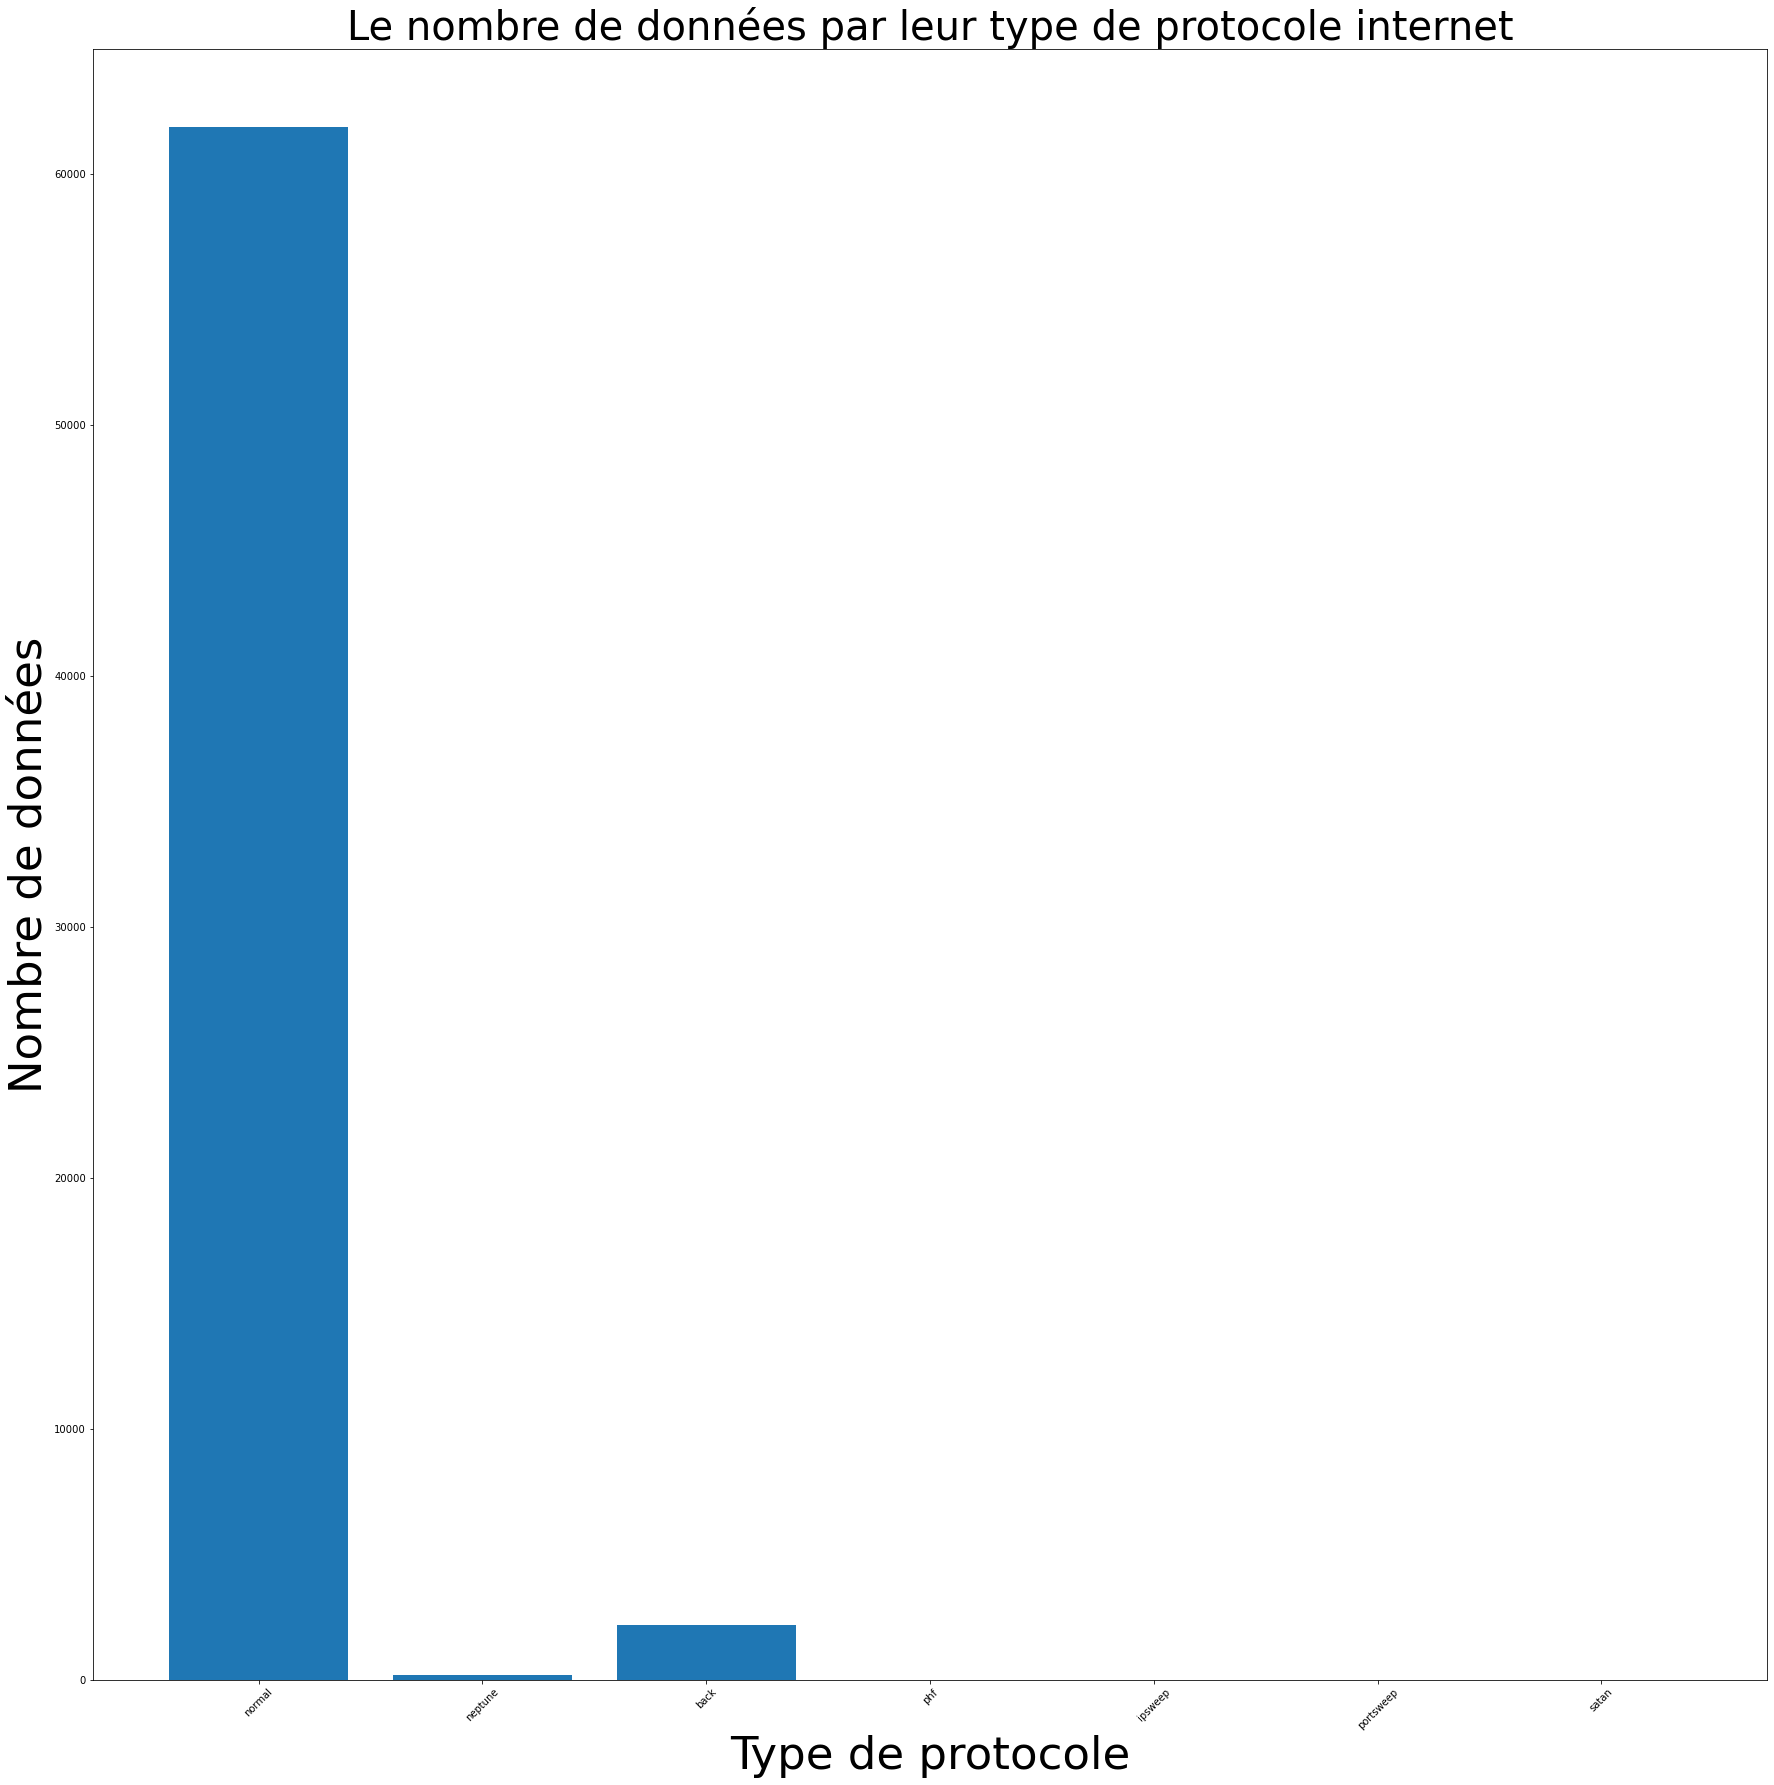

In [8]:
df=dataset
z1 = df[(df.outcome == 'normal.')]
z2 = df[(df.outcome == 'neptune.')]
z3 = df[(df.outcome == 'back.')]
z4 = df[(df.outcome == 'phf.')]
z5 = df[(df.outcome == 'ipsweep.')]
z6 = df[(df.outcome == 'portsweep.')]
z7 = df[(df.outcome == 'satan.')]

c = ["normal","neptune","back","phf","ipsweep","portsweep","satan"]
v = [len(z1),len(z2),len(z3),len(z4),len(z5),len(z6),len(z7)]

plt.figure(figsize=(30, 30))
plt.bar(c, v)

plt.xticks(rotation = 45)
plt.xlabel("Type de protocole",fontsize = 45)
plt.ylabel("Nombre de données",fontsize = 45)
plt.title("Le nombre de données par leur type de protocole internet",fontsize = 40)

<div style="margin-left: 250">
<img src="img/I-4.png" width="4000"/>
</div>

Pour prétraiter notre base de données, nous devons :

* Supprimez les fonctionnalités qui ne sont pas nécessaires
* Séparez les caractéristiques et les étiquettes
* Encoder les étiquettes catégorielles en nombres entiers

     > Pour encoder les étiquettes catégorielles, nous avons besoin de la fonction LabelEncoder qui est utilisée pour normaliser les étiquettes. Il peut également être utilisé pour transformer des étiquettes non numériques (tant qu'elles sont hachables et comparables) en étiquettes numériques. Monter l'encodeur d'étiquette. Installez l'encodeur d'étiquettes et renvoyez les étiquettes codées.
* Encodage à chaud des étiquettes

     > Un encodage à chaud est un processus de conversion de variables de données catégorielles afin qu'elles puissent être fournies aux algorithmes d'apprentissage automatique pour améliorer les prédictions. Un encodage à chaud est un élément crucial de l'ingénierie des fonctionnalités pour l'apprentissage automatique.

* Fonctionnalité de mise à l'échelle des données d'entrée


In [9]:
# Drop the features that are not required
dataset = dataset.drop(dataset.columns[[0, 1, 2, 3, 6, 11, 13, 14, 15, 20, 21]], axis=1)

# Separate the features and labels
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

# Encode the categorical labels into integers
label_encoder_y = LabelEncoder()
y = label_encoder_y.fit_transform(y)

# One-hot encoding the labels
onehotencoder = OneHotEncoder(categories='auto')
y = onehotencoder.fit_transform(y.reshape(-1, 1)).toarray()

# Feature scaling the input data
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [10]:
X

array([[-0.19374   ,  0.06287188,  0.        , ..., -0.06568139,
        -0.31953643, -0.32350066],
       [-0.1878376 , -0.19854594,  0.        , ..., -0.06568139,
        -0.31953643, -0.32350066],
       [-0.18824467, -0.15372995,  0.        , ..., -0.06568139,
        -0.31953643, -0.32350066],
       ...,
       [-0.19150116, -0.16094474,  0.        , ...,  0.1299207 ,
        -0.31953643, -0.32350066],
       [-0.1825458 , -0.16094474,  0.        , ...,  0.1299207 ,
        -0.31953643, -0.32350066],
       [-0.18987291, -0.15915421,  0.        , ...,  0.1299207 ,
        -0.31953643, -0.32350066]])

In [11]:
y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

<div style="margin-left: 250">
<img src="img/I-5.png" width="4000"/>
</div>

Fractionnement d'une base de données en ensembles d'entraînement et de test à l'aide de la fonction **train_test_split** à partir d'une bibliothèque d'apprentissage automatique, telle que scikit-learn. Voici une ventilation du code :

- **X** représente les caractéristiques ou les variables indépendantes de votre jeu de données.
- **y** représente la cible ou la variable dépendante que vous souhaitez prédire ou classer.
- **test_size=0.3** indique que 30 % des données seront utilisées pour les tests, tandis que 70 % seront utilisées pour la formation.
- **random_state=42** définit une graine aléatoire spécifique, garantissant que la répartition des données est reproductible. La valeur "42" est arbitraire et peut être n'importe quel autre nombre entier.
- **X_train :** L'ensemble de fonctionnalités d'entraînement (70 % des données d'origine).
- **X_test :** L'ensemble de fonctionnalités de test (30 % des données d'origine).
- **y_train :** L'ensemble d'apprentissage des valeurs cibles correspondant aux données **X_train**.
- **y_test :** L'ensemble de test des valeurs cibles correspondant aux données **X_test**.

Ces divisions sont couramment utilisées dans l'apprentissage automatique pour évaluer les performances d'un modèle en l'entraînant sur l'ensemble d'apprentissage, puis en le testant sur l'ensemble de test invisible.

In [12]:
#Split the database into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

<br><br><br><br><br><br>

<div style="margin-left: 250">
<img src="img/II-1.png" width="4000"/>
</div>

**l'algorithme CNN** est le **plus précis** et le plus efficace pour détecter les intrusions simplement en comparant la performance de la masseuse pour chaque algorithme, et pour cela, je doit utiliser **l'algorithme CNN** comme algorithme principal pour mon étude sur la détection d'intrusion à l'aide de l'apprentissage en profondeur.

<div style="margin-left: 250">
<img src="img/II-2.png" width="4000"/>
</div>

### **Création du modèle 1 de CNN**

Création d'un modèle CNN pour un problème de classification à l'aide de couches Keras :


1. Crée une instance de la classe Sequential, qui est un modèle Keras.

2. Ajoute une **couche convolutive 1D** au modèle avec **64 filtres**, une taille de noyau de **3** et une fonction d'activation **ReLU**. La forme d'entrée est spécifiée sous la forme **(X_train.shape[1], 1)**, ce qui signifie que les données d'entrée sont **unidimensionnelles** et que le nombre d'entités est égal à **X_train.shape[1] **.

3. Ajoute une **couche de pooling** maximale au modèle avec une taille de pool de **2**.

4. Ajoute une autre **couche convolutive 1D** au modèle avec **32 filtres**, une taille de noyau de **3** et une fonction d'activation **ReLU**.

5. Ajoute une autre **couche de pooling** max au modèle avec une taille de pool de **2**.

6. **Aplatit** la sortie des **couches convolutives** en un tableau **à une dimension**.

7. Ajoute une **couche entièrement connectée** au modèle avec **128 neurones** et une fonction d'activation **ReLU**.

8. Ajoute une **couche de suppression** au modèle avec un taux de suppression de **0,2**. L'abandon est une technique de régularisation qui abandonne aléatoirement **(met à zéro)** certains des neurones de la couche pendant l'entraînement, **ce qui aide à prévenir le surajustement**.

9. Ajoute la **couche de sortie** au modèle. Le nombre de neurones dans la couche de sortie est **égal** au nombre de classes dans le problème, qui est **y_train.shape[1]**. La fonction d'activation utilisée est **softmax**, qui produit une distribution de probabilité sur les classes.

10. Compile le modèle en spécifiant l'optimiseur **(adam)**, la fonction de perte **(entropie croisée catégorielle)** et la métrique d'évaluation **(précision)**.

11. Imprime un résumé de l'architecture du modèle, y compris les couches, le nombre de paramètres et les formes de sortie.

> Crée un modèle CNN avec deux couches convolutives 1D, deux couches de regroupement maximum, une couche entièrement connectée, une couche d'abandon et une couche de sortie. Le modèle est compilé avec l'optimiseur Adam et la fonction de perte d'entropie croisée catégorielle, et est évalué à l'aide de la métrique de précision.

In [13]:
classifier = Sequential()

# Add convolutional layer
classifier.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))

# Add max pooling layer
classifier.add(MaxPooling1D(pool_size=2))

# Add another convolutional layer
classifier.add(Conv1D(filters=32, kernel_size=3, activation='relu'))

# Add max pooling layer
classifier.add(MaxPooling1D(pool_size=2))

# Flatten the output from convolutional layers
classifier.add(Flatten())

# Add fully connected layer
classifier.add(Dense(units=128, activation='relu'))

# Add dropout layer to prevent overfitting
classifier.add(Dropout(rate=0.2))

# Add output layer
classifier.add(Dense(units=y_train.shape[1], activation='softmax'))

# Compile the model
classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 28, 64)            256       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 14, 64)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 12, 32)            6176      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 6, 32)            0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 192)               0         
                                                                 
 dense (Dense)               (None, 128)               2

### **Création du modèle 2 de CNN**

**Modèle 2 :** Remplacez la fonction d'activation par **LeakyReLU**, l'optimiseur par **RMSprop**, la fonction de perte par **mean squared error** et **augmentez** le taux d'abandon.

In [14]:
from keras.layers import LeakyReLU
from keras.optimizers import RMSprop

# Model 2
classifier2 = Sequential()

classifier2.add(Conv1D(filters=128, kernel_size=3, activation=LeakyReLU(alpha=0.2), input_shape=(X_train.shape[1], 1)))
classifier2.add(MaxPooling1D(pool_size=2))
classifier2.add(Conv1D(filters=64, kernel_size=3, activation=LeakyReLU(alpha=0.2)))
classifier2.add(MaxPooling1D(pool_size=2))
classifier2.add(Flatten())
classifier2.add(Dense(units=256, activation=LeakyReLU(alpha=0.2)))
classifier2.add(Dropout(rate=0.4))
classifier2.add(Dense(units=y_train.shape[1], activation='softmax'))

classifier2.compile(optimizer=RMSprop(), loss='mean_squared_error', metrics=['accuracy'])
classifier2.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 28, 128)           512       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 14, 128)          0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 12, 64)            24640     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 6, 64)            0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 384)               0         
                                                                 
 dense_2 (Dense)             (None, 256)              

### **Création du modèle CNN 3**
**Modèle 3 :** Modifiez la fonction d'activation en **tanh**, l'optimiseur en **SGD**, la fonction de **binary cross-entropy** et diminuez le taux d'abandon.

In [18]:
from keras.optimizers import SGD

# Model 3
classifier3 = Sequential()

classifier3.add(Conv1D(filters=32, kernel_size=3, activation='tanh', input_shape=(X_train.shape[1], 1)))
classifier3.add(MaxPooling1D(pool_size=2))
classifier3.add(Conv1D(filters=16, kernel_size=3, activation='tanh'))
classifier3.add(MaxPooling1D(pool_size=2))
classifier3.add(Flatten())
classifier3.add(Dense(units=64, activation='tanh'))
classifier3.add(Dropout(rate=0.1))
classifier3.add(Dense(units=y_train.shape[1], activation='softmax'))

classifier3.compile(optimizer=SGD(), loss='binary_crossentropy', metrics=['accuracy'])
classifier3.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 28, 32)            128       
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 14, 32)           0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 12, 16)            1552      
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 6, 16)            0         
 1D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 96)                0         
                                                                 
 dense_4 (Dense)             (None, 64)               

Dans ces exemples, j'ai changé la fonction d'activation en LeakyReLU et tanh, l'optimiseur en RMSprop et SGD, la fonction de perte pour signifier l'erreur au carré et l'entropie croisée binaire, et j'ai ajusté le taux d'abandon. Ces changements peuvent influencer le comportement d'apprentissage du modèle et potentiellement avoir un impact sur la précision. N'oubliez pas de sélectionner les fonctions d'activation, les optimiseurs et les fonctions de perte appropriés en fonction de votre tâche spécifique et des caractéristiques de l'ensemble de données.

N'hésitez pas à modifier d'autres paramètres ou à explorer différentes combinaisons pour approfondir leurs effets sur les performances du modèle.

<div style="margin-left: 250">
<img src="img/II-3.png" width="4000"/>
</div>

Entraînez un modèle d'apprentissage automatique à l'aide d'un réseau neuronal d'apprentissage en profondeur appelé "classificateur" sur certaines données d'entrée **X_train** avec les données de sortie correspondantes **y_train**.

Le but du réseau neuronal est de prédire les valeurs de sortie **(y)** pour les nouvelles valeurs d'entrée **(X)** qu'il n'a pas vues auparavant.

La méthode **"fit"** de l'objet **"classifier"** est utilisée pour entraîner le réseau de neurones.

La méthode **"fit"** prend en compte les données d'entrée et les données de sortie ainsi que d'autres paramètres :

 

* **X_train.reshape(X_train.shape[0], X_train.shape[1], 1)** - Cela remodèle les données d'entrée en un tableau 3D. La première dimension est le nombre d'exemples d'apprentissage, la deuxième dimension est la longueur de chaque séquence d'entrée et la troisième dimension est le nombre de fonctionnalités (dans ce cas, il n'y a qu'une seule fonctionnalité). Ceci est nécessaire pour la forme d'entrée du réseau neuronal.

* **y_train** - Il s'agit des données de sortie qui correspondent aux données d'entrée.

* **epochs=10** - Cela spécifie le nombre de fois que l'ensemble de données sera passé à travers le réseau de neurones pendant la formation.

* **batch_size=128** - Ceci spécifie le nombre d'échantillons qui seront utilisés dans chaque itération de formation. Dans ce cas, les données d'apprentissage seront divisées en lots de 128 échantillons et le réseau de neurones sera formé sur chaque lot.

* **validation_data=(X_test.reshape(X_test.shape[0], X_test.shape[1], 1), y_test)** - Ceci spécifie les données de validation, qui sont utilisées pour évaluer les performances du réseau de neurones pendant entraînement. Les données de validation sont également remodelées en un tableau 3D.

>La sortie de la méthode **"fit"** est stockée dans la variable **"history"**. Cet objet contient des informations sur les performances du réseau de neurones pendant la formation, telles que la perte de formation et de validation et la précision pour chaque époque.









### **Formation du modèle CNN 1**

In [15]:
import time
# Start the timer
start_time = time.time()
# Train cnn model 1
history = classifier.fit(X_train.reshape(X_train.shape[0], X_train.shape[1], 1), y_train, epochs=10, batch_size=128, validation_data=(X_test.reshape(X_test.shape[0], X_test.shape[1], 1), y_test))
# End the timer
end_time = time.time()
execution_time1 = end_time - start_time

# Print Execution time
print("+------------------------------------------+")
print("|Execution time:", execution_time1, "seconds|")
print("+------------------------------------------+")


Epoch 1/10
352/352 [==============================] - 2s 4ms/step - loss: 0.1020 - accuracy: 0.9907 - val_loss: 0.0066 - val_accuracy: 0.9991
Epoch 2/10
352/352 [==============================] - 1s 4ms/step - loss: 0.0054 - accuracy: 0.9992 - val_loss: 0.0040 - val_accuracy: 0.9993
Epoch 3/10
352/352 [==============================] - 1s 4ms/step - loss: 0.0021 - accuracy: 0.9994 - val_loss: 0.0049 - val_accuracy: 0.9996
Epoch 4/10
352/352 [==============================] - 1s 4ms/step - loss: 0.0018 - accuracy: 0.9998 - val_loss: 0.0022 - val_accuracy: 0.9997
Epoch 5/10
352/352 [==============================] - 2s 6ms/step - loss: 0.0013 - accuracy: 0.9997 - val_loss: 0.0026 - val_accuracy: 0.9997
Epoch 6/10
352/352 [==============================] - 2s 6ms/step - loss: 0.0016 - accuracy: 0.9997 - val_loss: 0.0011 - val_accuracy: 0.9999
Epoch 7/10
352/352 [==============================] - 2s 4ms/step - loss: 3.5045e-04 - accuracy: 0.9999 - val_loss: 0.0011 - val_accuracy: 0.9999
Ep

### **Formation du modèle CNN 2**

In [16]:
import time
# Start the timer
start_time = time.time()
# Train cnn model 2
history2 = classifier2.fit(X_train.reshape(X_train.shape[0], X_train.shape[1], 1), y_train, epochs=10, batch_size=128, validation_data=(X_test.reshape(X_test.shape[0], X_test.shape[1], 1), y_test))
# End the timer
end_time = time.time()
execution_time2 = end_time - start_time

# Print Execution time
print("+------------------------------------------+")
print("|Execution time:", execution_time2, "seconds|")
print("+------------------------------------------+")

Epoch 1/10
352/352 [==============================] - 3s 8ms/step - loss: 0.0020 - accuracy: 0.9930 - val_loss: 9.1232e-04 - val_accuracy: 0.9967
Epoch 2/10
352/352 [==============================] - 2s 7ms/step - loss: 0.0011 - accuracy: 0.9960 - val_loss: 8.6743e-04 - val_accuracy: 0.9970
Epoch 3/10
352/352 [==============================] - 2s 6ms/step - loss: 0.0011 - accuracy: 0.9963 - val_loss: 7.8499e-04 - val_accuracy: 0.9973
Epoch 4/10
352/352 [==============================] - 2s 6ms/step - loss: 0.0010 - accuracy: 0.9964 - val_loss: 7.8591e-04 - val_accuracy: 0.9973
Epoch 5/10
352/352 [==============================] - 2s 6ms/step - loss: 0.0010 - accuracy: 0.9964 - val_loss: 7.8396e-04 - val_accuracy: 0.9973
Epoch 6/10
352/352 [==============================] - 2s 6ms/step - loss: 0.0010 - accuracy: 0.9964 - val_loss: 8.0944e-04 - val_accuracy: 0.9971
Epoch 7/10
352/352 [==============================] - 2s 6ms/step - loss: 0.0010 - accuracy: 0.9964 - val_loss: 7.8500e-04 -

### **Formation du modèle CNN 3**

In [19]:
import time
# Start the timer
start_time = time.time()
# Train cnn model 3
history3 = classifier3.fit(X_train.reshape(X_train.shape[0], X_train.shape[1], 1), y_train, epochs=10, batch_size=128, validation_data=(X_test.reshape(X_test.shape[0], X_test.shape[1], 1), y_test))
# End the timer
end_time = time.time()
execution_time3 = end_time - start_time

# Print Execution time
print("+------------------------------------------+")
print("|Execution time:", execution_time3, "seconds|")
print("+------------------------------------------+")

Epoch 1/10
352/352 [==============================] - 2s 5ms/step - loss: 0.3215 - accuracy: 0.9190 - val_loss: 0.1056 - val_accuracy: 0.9637
Epoch 2/10
352/352 [==============================] - 12s 34ms/step - loss: 0.0798 - accuracy: 0.9621 - val_loss: 0.0619 - val_accuracy: 0.9637
Epoch 3/10
352/352 [==============================] - 8s 22ms/step - loss: 0.0587 - accuracy: 0.9621 - val_loss: 0.0517 - val_accuracy: 0.9637
Epoch 4/10
352/352 [==============================] - 10s 27ms/step - loss: 0.0512 - accuracy: 0.9621 - val_loss: 0.0463 - val_accuracy: 0.9637
Epoch 5/10
352/352 [==============================] - 7s 19ms/step - loss: 0.0464 - accuracy: 0.9621 - val_loss: 0.0424 - val_accuracy: 0.9637
Epoch 6/10
352/352 [==============================] - 7s 20ms/step - loss: 0.0426 - accuracy: 0.9621 - val_loss: 0.0390 - val_accuracy: 0.9637
Epoch 7/10
352/352 [==============================] - 7s 20ms/step - loss: 0.0393 - accuracy: 0.9621 - val_loss: 0.0358 - val_accuracy: 0.963

<div style="margin-left: 250">
<img src="img/II-4.png" width="4000"/>
</div>

La méthode "evaluate" prend les paramètres suivants :

* **X_test.reshape((X_test.shape[0], X_test.shape[1], 1))** - Cela remodèle les données d'entrée du test au même format de tableau 3D utilisé pendant la formation. La première dimension est le nombre d'exemples de test, la deuxième dimension est la longueur de chaque séquence d'entrée et la troisième dimension est le nombre de fonctionnalités (dans ce cas, il n'y a qu'une seule fonctionnalité).

* **y_test** - Il s'agit des données de sortie correspondantes pour les données d'entrée de test.

* **verbose=0** - Ceci spécifie le niveau de verbosité du processus d'évaluation. Une valeur de 0 signifie qu'aucun message de progression ne sera affiché pendant l'évaluation.

>La sortie de la méthode "evaluate" est stockée dans la variable "score". La variable "score" contient une valeur scalaire qui représente la performance globale du modèle sur les données de test. La métrique spécifique utilisée pour l'évaluation dépend du type de modèle et du problème à résoudre. Par exemple, si le modèle est un classificateur, la métrique peut être l'exactitude, la précision ou le rappel. Si le modèle est un régresseur, la métrique peut être l'erreur quadratique moyenne ou l'erreur absolue moyenne.

### **Évaluer la précision et la perte des 3 modèles**

Model 1 - Test loss: 0.13%
Model 1 - Test accuracy: 99.99%
Model 2 - Test loss: 0.08%
Model 2 - Test accuracy: 99.72%
Model 3 - Test loss: 2.59%
Model 3 - Test accuracy: 96.37%


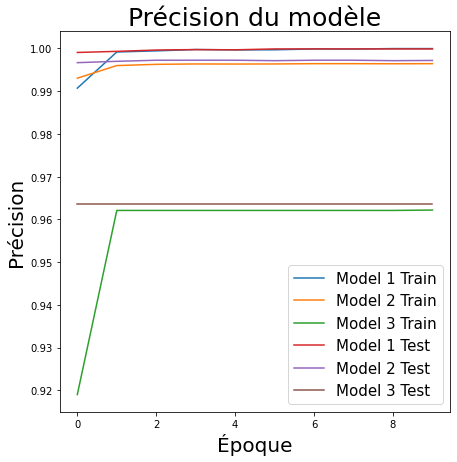

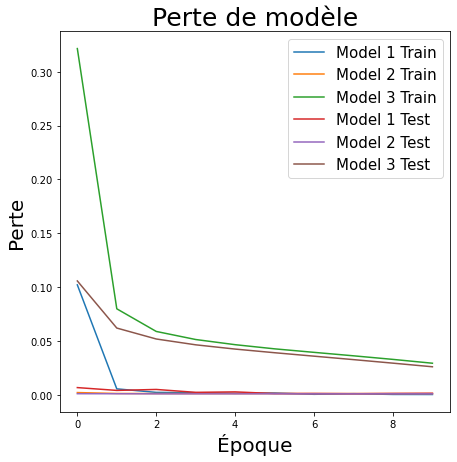

In [25]:
# Plot the accuracy and loss curves
import matplotlib.pyplot as plt
# Get the Score of evaluating CNN 1
score1 = classifier.evaluate(X_test.reshape((X_test.shape[0], X_test.shape[1], 1)), y_test, verbose=0)
print('Model 1 - Test loss: {:.2%}'.format(score1[0]))  # Display test loss as a percentage
print('Model 1 - Test accuracy: {:.2%}'.format(score1[1]))  # Display test accuracy as a percentage

# Get the Score of evaluating CNN 2
score2 = classifier2.evaluate(X_test.reshape((X_test.shape[0], X_test.shape[1], 1)), y_test, verbose=0)
print('Model 2 - Test loss: {:.2%}'.format(score2[0]))  # Display test loss as a percentage
print('Model 2 - Test accuracy: {:.2%}'.format(score2[1]))  # Display test accuracy as a percentage

# Get the Score of evaluating CNN 3
score3 = classifier3.evaluate(X_test.reshape((X_test.shape[0], X_test.shape[1], 1)), y_test, verbose=0)
print('Model 3 - Test loss: {:.2%}'.format(score3[0]))  # Display test loss as a percentage
print('Model 3 - Test accuracy: {:.2%}'.format(score3[1]))  # Display test accuracy as a percentage


# Plot accuracy
plt.figure(figsize=(7, 7))
plt.plot(history.history['accuracy'])
plt.plot(history2.history['accuracy'])
plt.plot(history3.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Précision du modèle',fontsize="25")
plt.ylabel('Précision',fontsize="20")
plt.xlabel('Époque',fontsize="20")
plt.legend(['Model 1 Train', 'Model 2 Train', 'Model 3 Train', 'Model 1 Test', 'Model 2 Test', 'Model 3 Test'], loc='lower right',fontsize="15")
plt.show()

# Plot loss
plt.figure(figsize=(7, 7))
plt.plot(history.history['loss'])
plt.plot(history2.history['loss'])
plt.plot(history3.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history2.history['val_loss'])
plt.plot(history3.history['val_loss'])
plt.title('Perte de modèle',fontsize="25")
plt.ylabel('Perte',fontsize="20")
plt.xlabel('Époque',fontsize="20")
plt.legend(['Model 1 Train', 'Model 2 Train', 'Model 3 Train', 'Model 1 Test', 'Model 2 Test', 'Model 3 Test'], loc='upper right',fontsize="15")
plt.show()

### **Évaluation de la précision des 3 modèles**

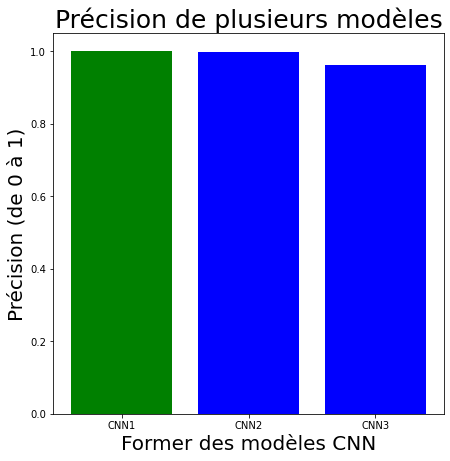

In [27]:
# Plot the accuracy
accuracy = [score1[1], score2[1], score3[1]]
labels = ['CNN1', 'CNN2', 'CNN3']
colors = ['blue', 'blue', 'blue']  # Set the color for each bar
# Find the index of the model with the highest accuracy
max_accuracy_index = accuracy.index(max(accuracy))
colors[max_accuracy_index] = 'green'  # Set a different color for the bar with the highest accuracy
plt.figure(figsize=(7, 7))
plt.bar(labels, accuracy, color=colors)
plt.xlabel('Former des modèles CNN',fontsize="20")
plt.ylabel('Précision (de 0 à 1)',fontsize="20")
plt.title('Précision de plusieurs modèles',fontsize="25")
plt.show()



### **Évaluation du temps d'exécution des 3 modèles**



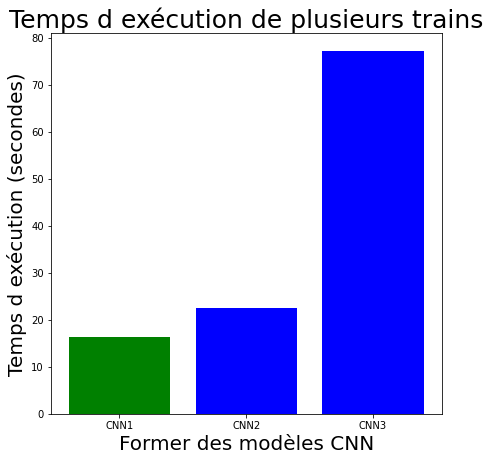

In [31]:
# Plot the execution times
execution_times = [execution_time1, execution_time2, execution_time3]
labels = ['CNN1', 'CNN2', 'CNN3']
colors = ['blue', 'blue', 'blue']  # Set the color for each bar

# Find the index of the model with the lowest execution time
min_execution_times_index = execution_times.index(min(execution_times))
colors[min_execution_times_index] = 'green'  # Set a different color for the bar with the execution time
plt.figure(figsize=(7, 7))
plt.bar(labels, execution_times, color=colors)
plt.xlabel('Former des modèles CNN',fontsize="20")
plt.ylabel('Temps d exécution (secondes)',fontsize="20")
plt.title('Temps d exécution de plusieurs trains',fontsize="25")
plt.show()

In [32]:
classifier.save('the_best_cnn_model.h5')

<br><br><br><br><br><br>

<div style="margin-left: 250">
<img src="img/III-1.png" width="4000"/>
</div>

Nous utilisions **3 exemples** de résultats pour voir à quel point ce modèle est vraiment précis.

<div style="margin-left: 250">
<img src="img/III-2.png" width="4000"/>
</div>

### **Créer l'exemple de test 1**

In [155]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
database2 = {
    'duration': [125],  
    'protocol_type': ['tcp'],  
    'service': ['ftp_data'],  
    'flag': ['SF'],  
    'src_bytes': [235],
    'dst_bytes': [370],
    'land': [0],  
    'wrong_fragment': [0],
    'urgent': [0],
    'hot': [0],
    'num_failed_logins': [0],
    'logged_in': [0],  
    'num_compromised': [1],
    'root_shell': [0],  
    'su_attempted': [0],  
    'num_root': [1],  
    'num_file_creations': [0],
    'num_shells': [0],
    'num_access_files': [0],
    'num_outbound_cmds': [0],
    'is_host_login': [0],  
    'is_guest_login': [0],  
    'count': [8],
    'srv_count': [8],
    'serror_rate': [0.0],
    'srv_serror_rate': [0.0],
    'rerror_rate': [0.0],
    'srv_rerror_rate': [0.0],
    'same_srv_rate': [1.0],
    'diff_srv_rate': [0.0],
    'srv_diff_host_rate': [0.0],
    'dst_host_count': [255],
    'dst_host_srv_count': [9],
    'dst_host_same_srv_rate': [0.03],
    'dst_host_diff_srv_rate': [0.06],
    'dst_host_same_src_port_rate': [0.0],
    'dst_host_srv_diff_host_rate': [0.0],
    'dst_host_serror_rate': [0.0],
    'dst_host_srv_serror_rate': [0.0],
    'dst_host_rerror_rate': [0.0],
    'dst_host_srv_rerror_rate': [0.0],
    'outcome': ['back.']
}


df = pd.DataFrame(database2)

### **Préparation de l'exemple de test 1**

In [156]:
df = pd.DataFrame(database2)
# Drop the features that are not required
df = df.drop(df.columns[[0, 1, 2, 3, 6, 11, 13, 14, 15, 20, 21]], axis=1)

# Separate the features and labels
X2 = df.iloc[:, :-1].values
y2 = df.iloc[:, -1].values

# Encode the categorical labels into integers
label_encoder_y2 = LabelEncoder()
y2 = label_encoder_y2.fit_transform(y2.ravel())

# One-hot encoding the labels
onehotencoder = OneHotEncoder(categories='auto')
y2 = onehotencoder.fit_transform(y2.reshape(-1, 1)).toarray()

# Feature scaling the input data
scaler = StandardScaler()
X2 = scaler.fit_transform(X2)

# Reshape the modified example to match the original input shape
X2_reshaped = X2.reshape((1, 30, 1))

### **Tester l'exemple 1** 

In [158]:
import time
start_time = time.time()

# Make predictions on the modified example
predictions = classifier.predict(X2_reshaped)

# Decode the one-hot encoded predictions
# Reshape the predictions array
predictions_reshaped = predictions.argmax(axis=1).reshape(-1, 1)

# Inverse transform the predictions
decoded_predictions = label_encoder_y2.inverse_transform(onehotencoder.inverse_transform(predictions_reshaped))
# Calculate TP, TN, FP, FN
intrusion_types = ['neptune.', 'back.', 'phf.', 'ipsweep.', 'portsweep.', 'satan.', 'smurf.']
true_labels = label_encoder_y2.inverse_transform(y3.argmax(axis=1).reshape(-1, 1))

TP = np.sum(np.isin(decoded_predictions, intrusion_types) & np.isin(true_labels, intrusion_types))
TN = np.sum(~np.isin(decoded_predictions, intrusion_types) & ~np.isin(true_labels, intrusion_types))
FP = np.sum(np.isin(decoded_predictions, intrusion_types) & ~np.isin(true_labels, intrusion_types))
FN = np.sum(~np.isin(decoded_predictions, intrusion_types) & np.isin(true_labels, intrusion_types))

# Print the results
print("\033[97m --------------------------------------------")
print("\033[94m True Positive (TP):\033[92m", TP)
print("\033[94m True Negative (TN):\033[92m", TN)
print("\033[94m False Positive (FP):\033[92m", FP)
print("\033[94m False Negative (FN):\033[92m", FN)
print("\033[97m --------------------------------------------")
# End the time of execution
end_time = time.time()
execution_time3 = end_time - start_time

# Print the predictions
print("\033[94m Predictions:\033[92m", decoded_predictions)
# Print the time of execution
print("\033[94m Execution time:\033[92m", execution_time1, "seconds")
print("\033[97m --------------------------------------------")

1/1 [==============================] - 0s 12ms/step
 --------------------------------------------
 True Positive (TP): 1
 True Negative (TN): 0
 False Positive (FP): 0
 False Negative (FN): 0
 --------------------------------------------
 Predictions: ['back.']
 Execution time: 0.05821108818054199 seconds
 --------------------------------------------


C:\Users\AURES\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


<br><br><br>

<div style="margin-left: 250">
<img src="img/III-3.png" width="4000"/>
</div>

### **Créer l'exemple de test 2**

In [159]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

# Define the attack example
database3 = {
    'duration': [0],
    'protocol_type': ['icmp'],
    'service': ['eco_i'],
    'flag': ['OTH'],
    'src_bytes': [1032],
    'dst_bytes': [0],
    'land': [0],
    'wrong_fragment': [0],
    'urgent': [0],
    'hot': [0],
    'num_failed_logins': [0],
    'logged_in': [0],
    'num_compromised': [0],
    'root_shell': [0],
    'su_attempted': [0],
    'num_root': [0],
    'num_file_creations': [0],
    'num_shells': [0],
    'num_access_files': [0],
    'num_outbound_cmds': [0],
    'is_host_login': [0],
    'is_guest_login': [0],
    'count': [234],
    'srv_count': [78],
    'serror_rate': [0.0],
    'srv_serror_rate': [0.0],
    'rerror_rate': [1.0],
    'srv_rerror_rate': [1.0],
    'same_srv_rate': [0.34],
    'diff_srv_rate': [0.12],
    'srv_diff_host_rate': [0.01],
    'dst_host_count': [10],
    'dst_host_srv_count': [2],
    'dst_host_same_srv_rate': [0.2],
    'dst_host_diff_srv_rate': [0.8],
    'dst_host_same_src_port_rate': [0.0],
    'dst_host_srv_diff_host_rate': [0.0],
    'dst_host_serror_rate': [0.0],
    'dst_host_srv_serror_rate': [0.0],
    'dst_host_rerror_rate': [1.0],
    'dst_host_srv_rerror_rate': [1.0],
    'outcome': ['neptune.']
}

# Create a DataFrame from the example
df3 = pd.DataFrame(database3)

### **Préparation de l'exemple de test 2**

In [160]:
# Drop the features that are not required
df3 = df3.drop(df3.columns[[0, 1, 2, 3, 6, 11, 13, 14, 15, 20, 21]], axis=1)

# Separate the features and labels
X3 = df3.iloc[:, :-1].values
y3 = df3.iloc[:, -1].values

# Encode the categorical labels into integers
label_encoder_y3 = LabelEncoder()
y3 = label_encoder_y3.fit_transform(y3.ravel())

# One-hot encoding the labels
onehotencoder = OneHotEncoder(categories='auto')
y3 = onehotencoder.fit_transform(y3.reshape(-1, 1)).toarray()

# Feature scaling the input data
scaler = StandardScaler()
X3 = scaler.fit_transform(X3)

# Reshape the modified example to match the original input shape
X3_reshaped = X3.reshape((1, 30, 1))

### **Tester l'exemple 2** 

In [161]:
import time
start_time = time.time()

# Make predictions on the modified example
predictions3 = classifier.predict(X3_reshaped)

# Decode the one-hot encoded predictions
# Reshape the predictions array
predictions_reshaped3 = predictions3.argmax(axis=1).reshape(-1, 1)

# Inverse transform the predictions
decoded_predictions3 = label_encoder_y3.inverse_transform(onehotencoder.inverse_transform(predictions_reshaped3))
# Calculate TP, TN, FP, FN
intrusion_types = ['neptune.', 'back.', 'phf.', 'ipsweep.', 'portsweep.', 'satan.', 'smurf.']
true_labels = label_encoder_y3.inverse_transform(y3.argmax(axis=1).reshape(-1, 1))

TP = np.sum(np.isin(decoded_predictions3, intrusion_types) & np.isin(true_labels, intrusion_types))
TN = np.sum(~np.isin(decoded_predictions3, intrusion_types) & ~np.isin(true_labels, intrusion_types))
FP = np.sum(np.isin(decoded_predictions3, intrusion_types) & ~np.isin(true_labels, intrusion_types))
FN = np.sum(~np.isin(decoded_predictions3, intrusion_types) & np.isin(true_labels, intrusion_types))

# Print the results
print("\033[97m --------------------------------------------")
print("\033[94m True Positive (TP):\033[92m", TP)
print("\033[94m True Negative (TN):\033[92m", TN)
print("\033[94m False Positive (FP):\033[92m", FP)
print("\033[94m False Negative (FN):\033[92m", FN)
print("\033[97m --------------------------------------------")
# End the time of execution
end_time = time.time()
execution_time3 = end_time - start_time

# Print the predictions
print("\033[94m Predictions:\033[92m", decoded_predictions3)
# Print the time of execution
print("\033[94m Execution time:\033[92m", execution_time2, "seconds")
print("\033[97m --------------------------------------------")

1/1 [==============================] - 0s 18ms/step
 --------------------------------------------
 True Positive (TP): 1
 True Negative (TN): 0
 False Positive (FP): 0
 False Negative (FN): 0
 --------------------------------------------
 Predictions: ['neptune.']
 Execution time: 0.06083846092224121 seconds
 --------------------------------------------


C:\Users\AURES\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


<br><br><br>

<div style="margin-left: 250">
<img src="img/III-4.png" width="4000"/>
</div>

### **Créer l'exemple de test 3**

In [163]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

# Define the normal example
database4 = {
    'duration': [0],
    'protocol_type': ['tcp'],
    'service': ['http'],
    'flag': ['SF'],
    'src_bytes': [500],
    'dst_bytes': [1500],
    'land': [0],
    'wrong_fragment': [0],
    'urgent': [0],
    'hot': [0],
    'num_failed_logins': [0],
    'logged_in': [1],
    'num_compromised': [0],
    'root_shell': [0],
    'su_attempted': [0],
    'num_root': [0],
    'num_file_creations': [0],
    'num_shells': [0],
    'num_access_files': [0],
    'num_outbound_cmds': [0],
    'is_host_login': [0],
    'is_guest_login': [0],
    'count': [25],
    'srv_count': [25],
    'serror_rate': [0.0],
    'srv_serror_rate': [0.0],
    'rerror_rate': [0.0],
    'srv_rerror_rate': [0.0],
    'same_srv_rate': [1.0],
    'diff_srv_rate': [0.0],
    'srv_diff_host_rate': [0.0],
    'dst_host_count': [255],
    'dst_host_srv_count': [255],
    'dst_host_same_srv_rate': [1.0],
    'dst_host_diff_srv_rate': [0.0],
    'dst_host_same_src_port_rate': [0.0],
    'dst_host_srv_diff_host_rate': [0.0],
    'dst_host_serror_rate': [0.0],
    'dst_host_srv_serror_rate': [0.0],
    'dst_host_rerror_rate': [0.0],
    'dst_host_srv_rerror_rate': [0.0],
    'outcome': ['normal.']
}

# Create a DataFrame from the example
df4 = pd.DataFrame(database4)


### **Préparation de l'exemple de test 3**

In [164]:
# Drop the features that are not required
df4 = df4.drop(df4.columns[[0, 1, 2, 3, 6, 11, 13, 14, 15, 20, 21]], axis=1)

# Separate the features and labels
X4 = df4.iloc[:, :-1].values
y4 = df4.iloc[:, -1].values

# Encode the categorical labels into integers
label_encoder_y4 = LabelEncoder()
y4 = label_encoder_y4.fit_transform(y4.ravel())

# One-hot encoding the labels
onehotencoder = OneHotEncoder(categories='auto')
y4 = onehotencoder.fit_transform(y4.reshape(-1, 1)).toarray()

# Feature scaling the input data
scaler = StandardScaler()
X4 = scaler.fit_transform(X4)

# Reshape the modified example to match the original input shape
X4_reshaped = X4.reshape((1, 30, 1))


### **Tester l'exemple 3** 

In [166]:
import time
start_time = time.time()

# Make predictions on the modified example
predictions4 = classifier.predict(X4_reshaped)

# Decode the one-hot encoded predictions
# Reshape the predictions array
predictions_reshaped4 = predictions4.argmax(axis=1).reshape(-1, 1)

# Inverse transform the predictions
decoded_predictions4 = label_encoder_y4.inverse_transform(onehotencoder.inverse_transform(predictions_reshaped4))
# Calculate TP, TN, FP, FN
intrusion_types = ['neptune.', 'back.', 'phf.', 'ipsweep.', 'portsweep.', 'satan.', 'smurf.']
true_labels = label_encoder_y4.inverse_transform(y3.argmax(axis=1).reshape(-1, 1))

TP = np.sum(np.isin(decoded_predictions4, intrusion_types) & np.isin(true_labels, intrusion_types))
TN = np.sum(~np.isin(decoded_predictions4, intrusion_types) & ~np.isin(true_labels, intrusion_types))
FP = np.sum(np.isin(decoded_predictions4, intrusion_types) & ~np.isin(true_labels, intrusion_types))
FN = np.sum(~np.isin(decoded_predictions4, intrusion_types) & np.isin(true_labels, intrusion_types))

# Print the results
print("\033[97m --------------------------------------------")
print("\033[94m True Positive (TP):\033[92m", TP)
print("\033[94m True Negative (TN):\033[92m", TN)
print("\033[94m False Positive (FP):\033[92m", FP)
print("\033[94m False Negative (FN):\033[92m", FN)
print("\033[97m --------------------------------------------")
# End the time of execution
end_time = time.time()
execution_time3 = end_time - start_time

# Print the predictions
print("\033[94m Predictions:\033[92m", decoded_predictions4)
# Print the time of execution
print("\033[94m Execution time:\033[92m", execution_time3, "seconds")
print("\033[97m --------------------------------------------")

1/1 [==============================] - 0s 18ms/step
 --------------------------------------------
 True Positive (TP): 0
 True Negative (TN): 1
 False Positive (FP): 0
 False Negative (FN): 0
 --------------------------------------------
 Predictions: ['normal.']
 Execution time: 0.05791211128234863 seconds
 --------------------------------------------


C:\Users\AURES\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
